# 导入公共库

In [1]:
random_state=233

In [2]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import seaborn as sns
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# 检查数据集状态

## 读取数据集

In [7]:
accidents=pd.read_csv('./data/uk_accident/Accidents0515.csv', index_col='Accident_Index')
vehicles=pd.read_csv('./data/uk_accident/Vehicles0515.csv', index_col='Accident_Index', error_bad_lines=False, warn_bad_lines=False)

## 数据预处理

### 筛选特征

In [8]:
feat_to_use=[
    'Accident_Severity',
    'Longitude',
    'Latitude',
    'Engine_Capacity_(CC)',
    'Age_of_Vehicle',
    'Day_of_Week',
    'Vehicle_Type',
    'Vehicle_Manoeuvre',
    'Junction_Detail',
    '1st_Road_Class',
    'Junction_Location',
]

In [ ]:
uk_data=accidents.join(vehicles, how='outer')[feat_to_use]

### 清除空数据

In [9]:
def drop_empty(data):
    for col in data.columns:
        data=data[data[col]!=-1]
    return data.dropna()

In [10]:
uk_data=drop_empty(uk_data)

## 展示数据集

In [11]:
def show_severity_distribution(data, labels=['Slight', 'Serious', 'Fatal'], log=True):
    if not isinstance(data, pd.DataFrame):
        data=pd.DataFrame(data)
    val_cnt=pd.DataFrame(data.value_counts())
    val_cnt.sort_index(inplace=True, ascending=False)
    print(val_cnt)
    ratio=val_cnt[0].values
    print(f'ratio = {(ratio/np.min(ratio)).tolist()}')
    sns.barplot(
        x=labels, 
        y=val_cnt[0].values,
        log=log,
    )

                        0
Accident_Severity        
3                  831420
2                  103823
1                    7073
ratio = [117.54842358263821, 14.67877845327301, 1.0]


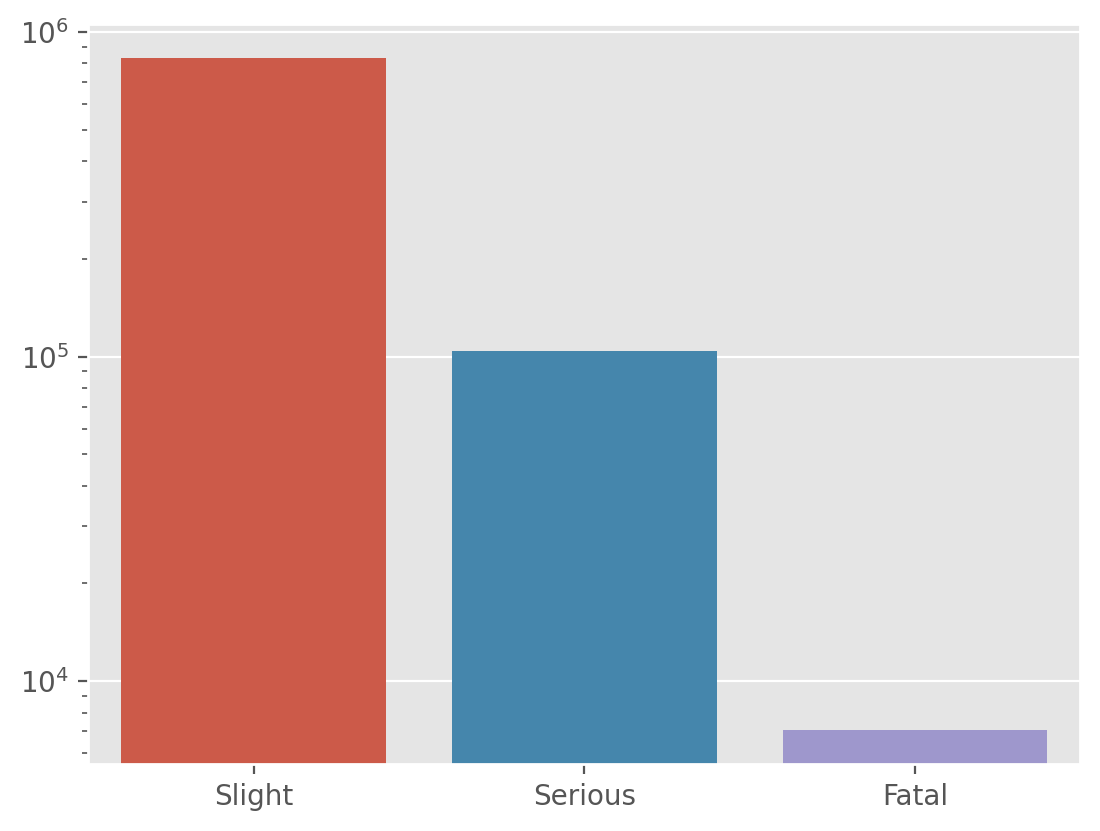

In [12]:
show_severity_distribution(uk_data.Accident_Severity)

三种程度的事故数量从轻到重逐级下降一个数量级

# 原始数据切分

In [13]:
def split_X_y(data, ylabels):
    y=data[ylabels]
    X=data.drop(labels=ylabels, axis=1)
    return X, y

In [14]:
X, y = split_X_y(uk_data, 'Accident_Severity')

In [12]:
# y[y==3] = 0
# y[y==2] = 1
# # y[y==1] = 1

In [15]:
print('数据量: %d, 特征量: %d' % X.shape)

数据量: 942316, 特征量: 51


                        0
Accident_Severity        
3                  831420
2                  103823
1                    7073
ratio = [117.54842358263821, 14.67877845327301, 1.0]


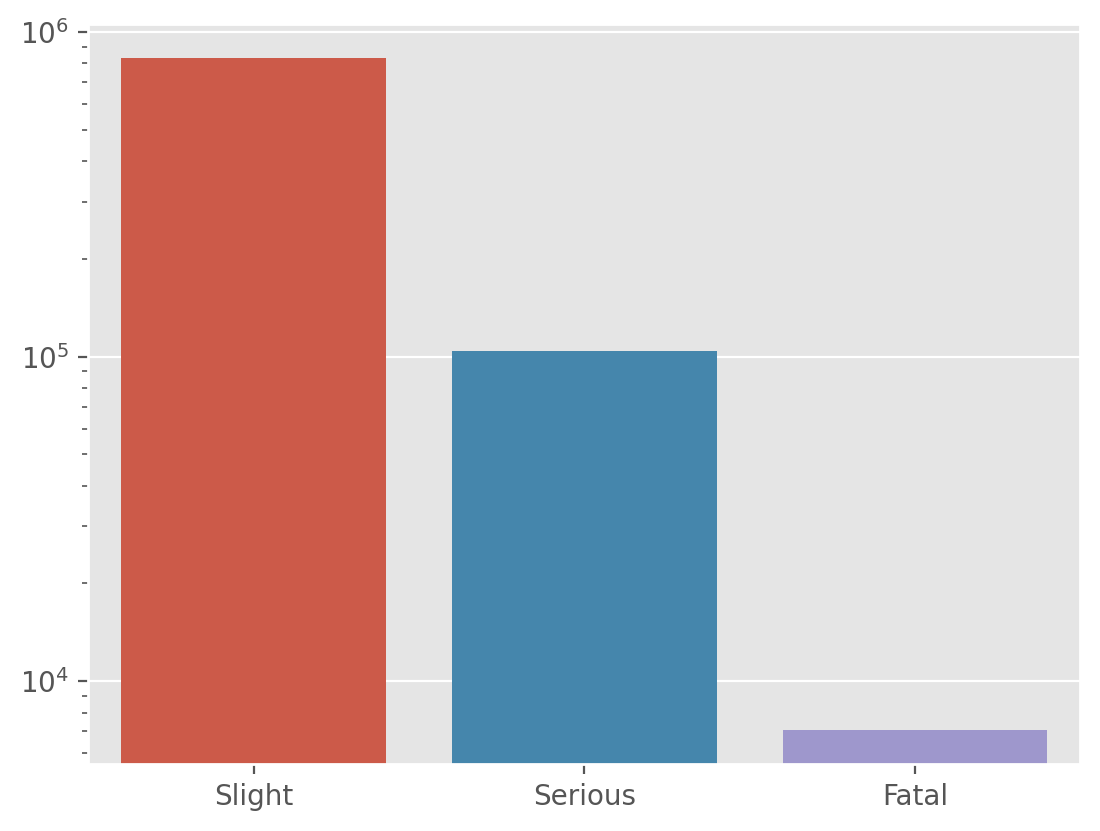

In [16]:
show_severity_distribution(y)

## 标准化

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

ValueError: could not convert string to float: '13/01/2005'

In [19]:
dump(scaler, './data/new_experiment/DataScaler')

['./data/new_experiment/DataScaler']

In [20]:
!ls -alh ./data/new_experiment/

total 47M
drwxr-xr-x 2 root root  115 Feb  8 13:08 .
drwxr-xr-x 6 root root   98 Feb  6 18:14 ..
-rw-r--r-- 1 root root  38M Feb  8 13:01 CombineSampledData-0515-SMOTETomek.npz
-rw-r--r-- 1 root root 1.2K Feb  8 13:08 DataScaler
-rw-r--r-- 1 root root 9.1M Feb  6 18:14 UnderSampledData-0515-RepeatedENN.npz


# 数据不平衡处理

In [3]:
def resample(sampler, data_X, data_y, random_state=0):
    t0=time()
    X_res, y_res = sampler.fit_resample(data_X, data_y)
    dt=time()-t0
    print(f'{sampler.__class__.__name__} 采样耗时: {dt/60.0 if dt > 60.0 else dt:.2f}{"s" if dt < 60.0 else "m"}')
    return X_res, y_res

## 欠采样

### RepeatedEditedNearestNeighbours

In [18]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [19]:
# renn=RepeatedEditedNearestNeighbours(sampling_strategy='majority', n_jobs=-1)
# us_renn_X, us_renn_y=resample(
#     renn,
#     data_X=X,
#     data_y=y
# )

In [20]:
# print(f'enn 运行次数 = {renn.n_iter_}')

In [21]:
# 保存数据
# np.savez_compressed(file='./data/new_experiment/UnderSampledData-0515-RepeatedENN', X=us_renn_X, y=us_renn_y)

In [22]:
!ls -alh data/new_experiment/

total 9.1M
drwxr-xr-x 2 root root   51 Feb  6 18:14 .
drwxr-xr-x 6 root root   98 Feb  6 18:14 ..
-rw-r--r-- 1 root root 9.1M Feb  6 18:14 UnderSampledData-0515-RepeatedENN.npz


In [3]:
# 读取数据
us_renn=np.load(file='./data/new_experiment/UnderSampledData-0515-RepeatedENN.npz')
us_renn_X, us_renn_y=us_renn['X'], us_renn['y']

        0
0        
3  896127
2  256313
1   28524
ratio = [31.416596550273454, 8.985871546767635, 1.0]


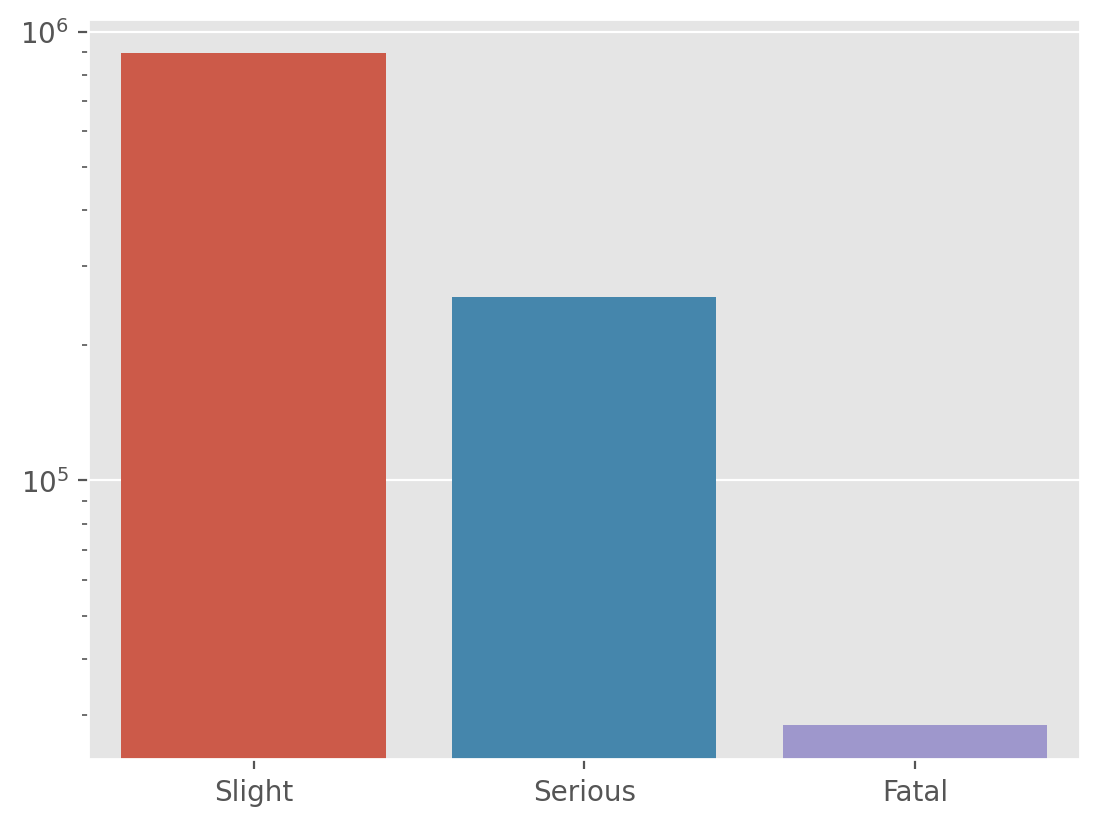

In [17]:
show_severity_distribution(us_renn_y)

## 过采样

### SMOTE

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
os_smote_X, os_smote_y=resample(
    SMOTE(n_jobs=-1, sampling_strategy='auto'),
    data_X=us_renn_X,
    data_y=us_renn_y,
)

SMOTE 采样耗时: 16.51s


        0
0        
3  896127
2  896127
1  896127
ratio = [1.0, 1.0, 1.0]


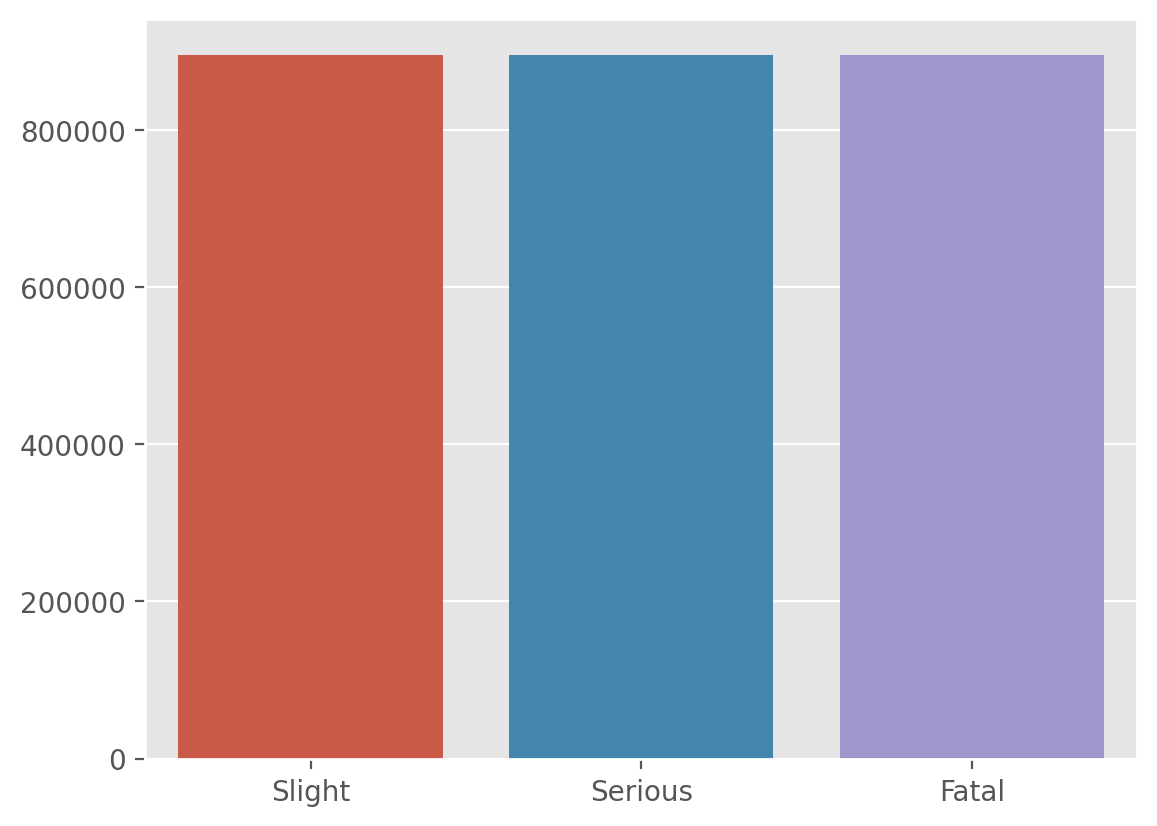

In [12]:
show_severity_distribution(os_smote_y, log=False)

## 混合采样

### SMOTETomek

In [18]:
from imblearn.combine import SMOTETomek

In [26]:
cs_X, cs_y=resample(
    SMOTETomek(n_jobs=-1, sampling_strategy='auto'),
    data_X=us_renn_X,
    data_y=us_renn_y,
)

SMOTETomek 采样耗时: 2.03m


In [59]:
# 保存数据
# np.savez_compressed(file='./data/new_experiment/CombineSampledData-0515-SMOTETomek', X=cs_X, y=cs_y)

In [8]:
!ls -alh data/new_experiment/

total 957M
drwxr-xr-x 3 root root 4.0K Feb 10 17:04 .
drwxr-xr-x 6 root root   98 Feb  6 18:14 ..
-rw-r--r-- 1 root root  38M Feb  8 13:01 CombineSampledData-0515-SMOTETomek.npz
-rw-r--r-- 1 root root 1.2K Feb  8 13:08 DataScaler
drwxr-xr-x 2 root root    6 Feb 10 16:09 .ipynb_checkpoints
-rw-r--r-- 1 root root 292M Feb 10 17:08 processed_data.npz
-rw-r--r-- 1 root root 275M Feb 10 13:21 raw_uk_data
-rw-r--r-- 1 root root  34M Feb  8 13:25 RENN_DecisionTree
-rw-r--r-- 1 root root  58M Feb  8 13:26 SMOTETomek_DecisionTree
-rw-r--r-- 1 root root 155M Feb 10 15:06 uk-0515-SMOTETomek_broken.npz
-rw-r--r-- 1 root root  96M Feb 10 17:04 uk-0515-SMOTETomek.npz
-rw-r--r-- 1 root root 9.1M Feb  6 18:14 UnderSampledData-0515-RepeatedENN.npz
-rw-r--r-- 1 root root 3.4M Feb  8 13:10 ValidData-1721.npz


In [3]:
# 读取数据
cs=np.load(file='./data/new_experiment/CombineSampledData-0515-SMOTETomek.npz')
cs_X, cs_y=cs['X'], cs['y']

In [10]:
show_severity_distribution(cs_y, log=False)

NameError: name 'show_severity_distribution' is not defined

# 机器学习

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
"""
拟合模型并评估模型
"""
def fit_predict(
    estimator, 
    data_x, 
    data_y, 
    valid_X=None, 
    valid_y=None, 
    test_size=0.2, 
    random_state=None, 
    need_confusion_matrix:bool=False, 
    confusion_normalize:str='true',
    need_classification_report:bool=False,
):
    X_train, X_test, y_train, y_test = train_test_split(
        data_x,
        data_y,
        test_size=test_size,
        random_state=0,
        stratify=data_y
    )
    
    # X_train
    
    # 执行训练
    t0=time()
    estimator.fit(X_train, y_train)
    print(f'{estimator.__class__.__name__} 训练耗时: {time()-t0:.2f}s')
    # 执行预测
    train_acc=accuracy_score(y_train, estimator.predict(X_train))
    y_pred=estimator.predict(X_test)
    test_acc=accuracy_score(y_test, y_pred)
    print(f'{estimator.__class__.__name__} [train_acc]={train_acc*100:.2f}')
    print(f'{estimator.__class__.__name__} [ test_acc]={test_acc*100:.2f}')
    valid_acc=None
    if valid_X is not None and valid_y is not None:
        valid_acc=accuracy_score(valid_y, estimator.predict(valid_X))
        print(f'{estimator.__class__.__name__} [valid_acc]={valid_acc*100:.2f}')
    
    if need_classification_report:
        print(classification_report(y_test, y_pred))
    
    return train_acc, \
            test_acc, \
            valid_acc, \
            confusion_matrix(y_test, y_pred, normalize=confusion_normalize) if need_confusion_matrix else None

In [5]:
from collections import defaultdict
"""
学习函数
"""
def learn(
    datasets, 
    get_estimators, 
    keep_all_models:bool=False, 
    validset:tuple=None, 
    show_confusion_matrix:bool=False,
    show_classification_report:bool=False,
    dpi:int=200,
):
    best_models=dict()
    n_datasets=len(datasets)
    n_estimators=len(get_estimators())
    if show_confusion_matrix:
        fig, axes=plt.subplots(n_datasets, n_estimators, dpi=dpi)
        if not isinstance(axes, np.ndarray):
            axes=np.array([axes])
        axes=axes.reshape(n_datasets, n_estimators) 
    
    if keep_all_models:
        all_models=defaultdict(dict)
            
    is_first_dataset=True
    for sampling_method_name, ax_row in zip(datasets.keys(), axes):
        print("="*10, f'sampling method -> [ {sampling_method_name} ]', "="*10)
        if not keep_all_models:
            top_acc=0.0
            top_model=None
        is_first_estimator=True
        for model, ax in zip(get_estimators(), ax_row):
            dx, dy = datasets[sampling_method_name]
            if validset is not None:
                vx, vy = validset
            else:
                vx, vy = None, None
            
            # 训练模型，并获取测试精度
            _, test_acc, valid_acc, confusion = fit_predict(model, dx, dy, vx, vy, random_state=random_state, need_confusion_matrix=show_confusion_matrix, need_classification_report=show_classification_report)
            
            if keep_all_models:
                # 保存所有模型
                all_models[sampling_method_name][f'{model.__class__.__name__}']={'model':model, 'acc': test_acc}            
            else:
                # 保存最优模型
                if valid_acc is not None and valid_acc > top_acc:
                    top_acc=valid_acc
                    top_model=model
                elif test_acc > top_acc:
                    top_acc=test_acc
                    top_model=model
            
                
            # 绘制混淆矩阵
            if show_confusion_matrix:
                # sns.heatmap(data=confusion, ax=ax, square=True, annot=True, fmt='.2g', linewidths=0.5)
                sns.heatmap(data=confusion, ax=ax, annot=True, cbar=False, fmt='.2g', linewidths=0.5, cmap='binary')
                if is_first_dataset:
                    ax.set_title(f'{model.__class__.__name__}')
                    is_first_dataset=False
                if is_first_estimator:
                    ax.set_ylabel(f'{sampling_method_name}')
                    is_first_estimator=False
        
        if not keep_all_models:        
            best_models[sampling_method_name]={'model':top_model, 'acc':top_acc}
        
    plt.show()
    
    return all_models if keep_all_models else best_models

## 重新采样后数据集

In [6]:
sampling_dataset={
    # 'RENN': (us_renn_X, us_renn_y),
    # 'SMOTE after RENN': (os_smote_X, os_smote_y),
    'SMOTETk': (cs_X, cs_y),
}

### 创建模型

#### HMM

In [3]:
import traceback
import numpy as np
from hmmlearn import hmm

class BABTM_HMM(object):
    def __init__(self, 
                n_components:int=2, 
                n_iter:int=1000, 
                m:str="multi") -> None:
        self.method="BABTM_HMM"
        if m == "gaussian":
            self.m=hmm.GaussianHMM
        else:
            # self.m=hmm.MultinomialHMM
            self.m=hmm.CategoricalHMM
        self.n_components=n_components
        self.n_iter=n_iter
        self.model=None
        self.acc=0.0
        
    def train(self, msgs):
        # 获取历史最优精度、最优模型
        best_acc=0.0
        best_model=None
        # 遍历数据，构造训练数据
        train_data=msgs
        train_cnt=1
        while best_model == None :
            print(f'[{train_cnt}] round fitting', end='\r')
            train_cnt+=1
            for i in range(1, len(train_data)):

                # print("="*60)
                # print(f"length={[i]*(i+1)}, n_trials={1}, seq_shape={np.array(train_data[:i+1]).reshape(-1, 1).shape}")
                # print("="*60)

                # 创建模型
                model=self.m(n_components=self.n_components, n_iter=self.n_iter)
                model.fit(np.array(train_data[:i+1]).reshape(-1, 1))
                # 获得预测
                pred=model.predict(np.array(train_data[:i+1]).reshape(-1, 1))
                # 计算预测表现
                ps=[train_data[:i+1][j] if p == 1 else -1 for j, p in enumerate(pred)]
                acc=sum([x == y for x, y in zip(train_data, ps)])/len(ps)
                if 1.0 > acc > best_acc and i > int(len(train_data)/2):
                    best_acc=acc
                    best_model=model
        
        # print(f"sender=[{sender}] has acc={best_acc}")
        self.acc=best_acc
        self.model=best_model

    def predict(self, msgs):        
        model=self.model
        if model == None :
            raise Exception('fuck liu han')
        pred=model.predict(np.array(msgs).reshape(-1, 1))
        # print(f'--------------------------------> pred={pred}')
        return pred
    
    def fit(self, data):
        return self.foward(data)

    def forward(self, data:tuple) -> tuple:
        # 构建历史数据
        msgHistory=[d[1] for d in data]

        self.acc=0.0
        self.model=None

        pred = None
        not_predicted = True
        while not_predicted :
            try: 
                self.train(msgHistory)
                pred=self.predict(msgHistory)
                not_predicted = False
            except Exception:
                not_predicted = True
                traceback.print_exc()     

        return tuple([m if p == 1  else -1 for p, m in zip(pred, msgHistory)])

    def __call__(self, data:tuple) -> tuple:
        return self.forward(data)

#### Bayes

In [2]:
import functools
from math import exp, tanh
import operator

class Bayes(object):
    def __init__(self, methodname: str, pe: tuple, beta: float, gamma: float, thr: float) -> None:
        self.pe=pe
        self.method=methodname
        self.beta=beta
        self.gamma=gamma
        self.thr=thr

    def credibility(self, vehicle):
        pass

    def postiriori(self, pe: float, pe_c: float, pc: float, pc_c: float):
        return ( pe * pc ) / ( ( pe * pc ) + ( pe_c * pc_c ) )
    
    def fit(self, data):
        return self.foward(data)

    def forward(self, data:tuple) -> tuple:
        ret=[]
        ps=[]
        creditGroup=dict()
        # 按顺序遍历数据
        for d in data:
            _, msgType, sender, _ = d
            # 1. 消息按类别分组
            if msgType not in creditGroup :
                # creditGroup[msgType]=1.0
                creditGroup[msgType]=[]
            # 2. 计算可信度
            # creditGroup[msgType]=(self.credibility(sender))
            creditGroup[msgType]+=[self.credibility(sender)]
            # 3.1 综合可信度，计算贝叶斯概率
            pe=self.pe[msgType]
            pe_c=1-pe
            # pc=creditGroup[msgType]
            pc=functools.reduce(operator.mul, creditGroup[msgType])
            # pc_c=1-pc
            pc_c=functools.reduce(operator.mul, [1-c for c in creditGroup[msgType]])
            # 3.2 计算贝叶斯后验概率
            # print(f'pe={pe}, pe_c={pe_c}, pc={pc}, pc_c={pc_c}')
            p=self.postiriori(pe, pe_c, pc, pc_c)
            ps+=[p]
            # 4. 记录预测
            ret.append(msgType if p >= self.thr else -1)
        # print(ps)
        return tuple(ret)

    def __call__(self, data:tuple) -> tuple:
        return self.forward(data)

class BDTM_Bayes(Bayes):
    def __init__(self, pe: tuple, beta: float, gamma: float, thr: float) -> None:
        super().__init__("BDTM_Bayes", pe, beta, gamma, thr)

    def credibility(self, vehicle):
        return self.beta + exp( -self.gamma * vehicle.distance )

    def __call__(self, data:tuple) -> tuple:
        return self.forward(data)


class EABTM_Bayes(Bayes):
    def __init__(self, pe: tuple, beta: float, gamma: float, thr: float, lambde:float) -> None:
        super().__init__("EABTM_Bayes", pe, beta, gamma, thr)
        self.lambde=lambde

    def credibility(self, vehicle):        
        return self.beta + exp( -self.gamma * vehicle.distance ) + tanh( self.lambde * vehicle.trust)

    def __call__(self, data:tuple) -> tuple:
        return self.forward(data)

class EABTM_Dot_Five_Bayes(Bayes):
    def __init__(self, pe: tuple, beta: float, gamma: float, thr: float, lambde:float) -> None:
        super().__init__("EABTM_Bayes_dot_0.5", pe, beta, gamma, thr)
        self.lambde=lambde

    def credibility(self, vehicle):        
        return self.beta + 0.5 * (exp( -self.gamma * vehicle.distance ) + tanh( self.lambde * vehicle.trust))

    def __call__(self, data:tuple) -> tuple:
        return self.forward(data)


# def tanh(x:float) -> float:
#     return ( exp(x) - exp(-x) ) / ( exp(x) + exp(-x) )

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

def us_models():
    return [
        # AdaBoostClassifier(n_estimators=100),
        DecisionTreeClassifier(random_state=random_state),
        # MLPClassifier(
        #     random_state=random_state,
        #     solver='sgd',
        #     learning_rate_init=0.3,
        #     learning_rate='adaptive',
        #     batch_size=200,
        #     hidden_layer_sizes=(18, 6),
        # ),
        # ExtraTreesClassifier(random_state=random_state),
        # RandomForestClassifier(random_state=random_state),
        OneVsOneClassifier(DecisionTreeClassifier(), n_jobs=-1),
        OneVsRestClassifier(DecisionTreeClassifier(), n_jobs=-1),
    ]

### 开始训练

========== sampling method -> [ SMOTETk ] ==========
DecisionTreeClassifier 训练耗时: 14.36s
DecisionTreeClassifier [train_acc]=99.22
DecisionTreeClassifier [ test_acc]=84.52
              precision    recall  f1-score   support

           1       0.87      0.88      0.87    173442
           2       0.79      0.76      0.77    172698
           3       0.87      0.89      0.88    177596

    accuracy                           0.85    523736
   macro avg       0.84      0.84      0.84    523736
weighted avg       0.84      0.85      0.84    523736

OneVsOneClassifier 训练耗时: 10.67s
OneVsOneClassifier [train_acc]=99.22
OneVsOneClassifier [ test_acc]=85.89
              precision    recall  f1-score   support

           1       0.91      0.90      0.90    173442
           2       0.82      0.78      0.80    172698
           3       0.85      0.90      0.88    177596

    accuracy                           0.86    523736
   macro avg       0.86      0.86      0.86    523736
weighted avg    

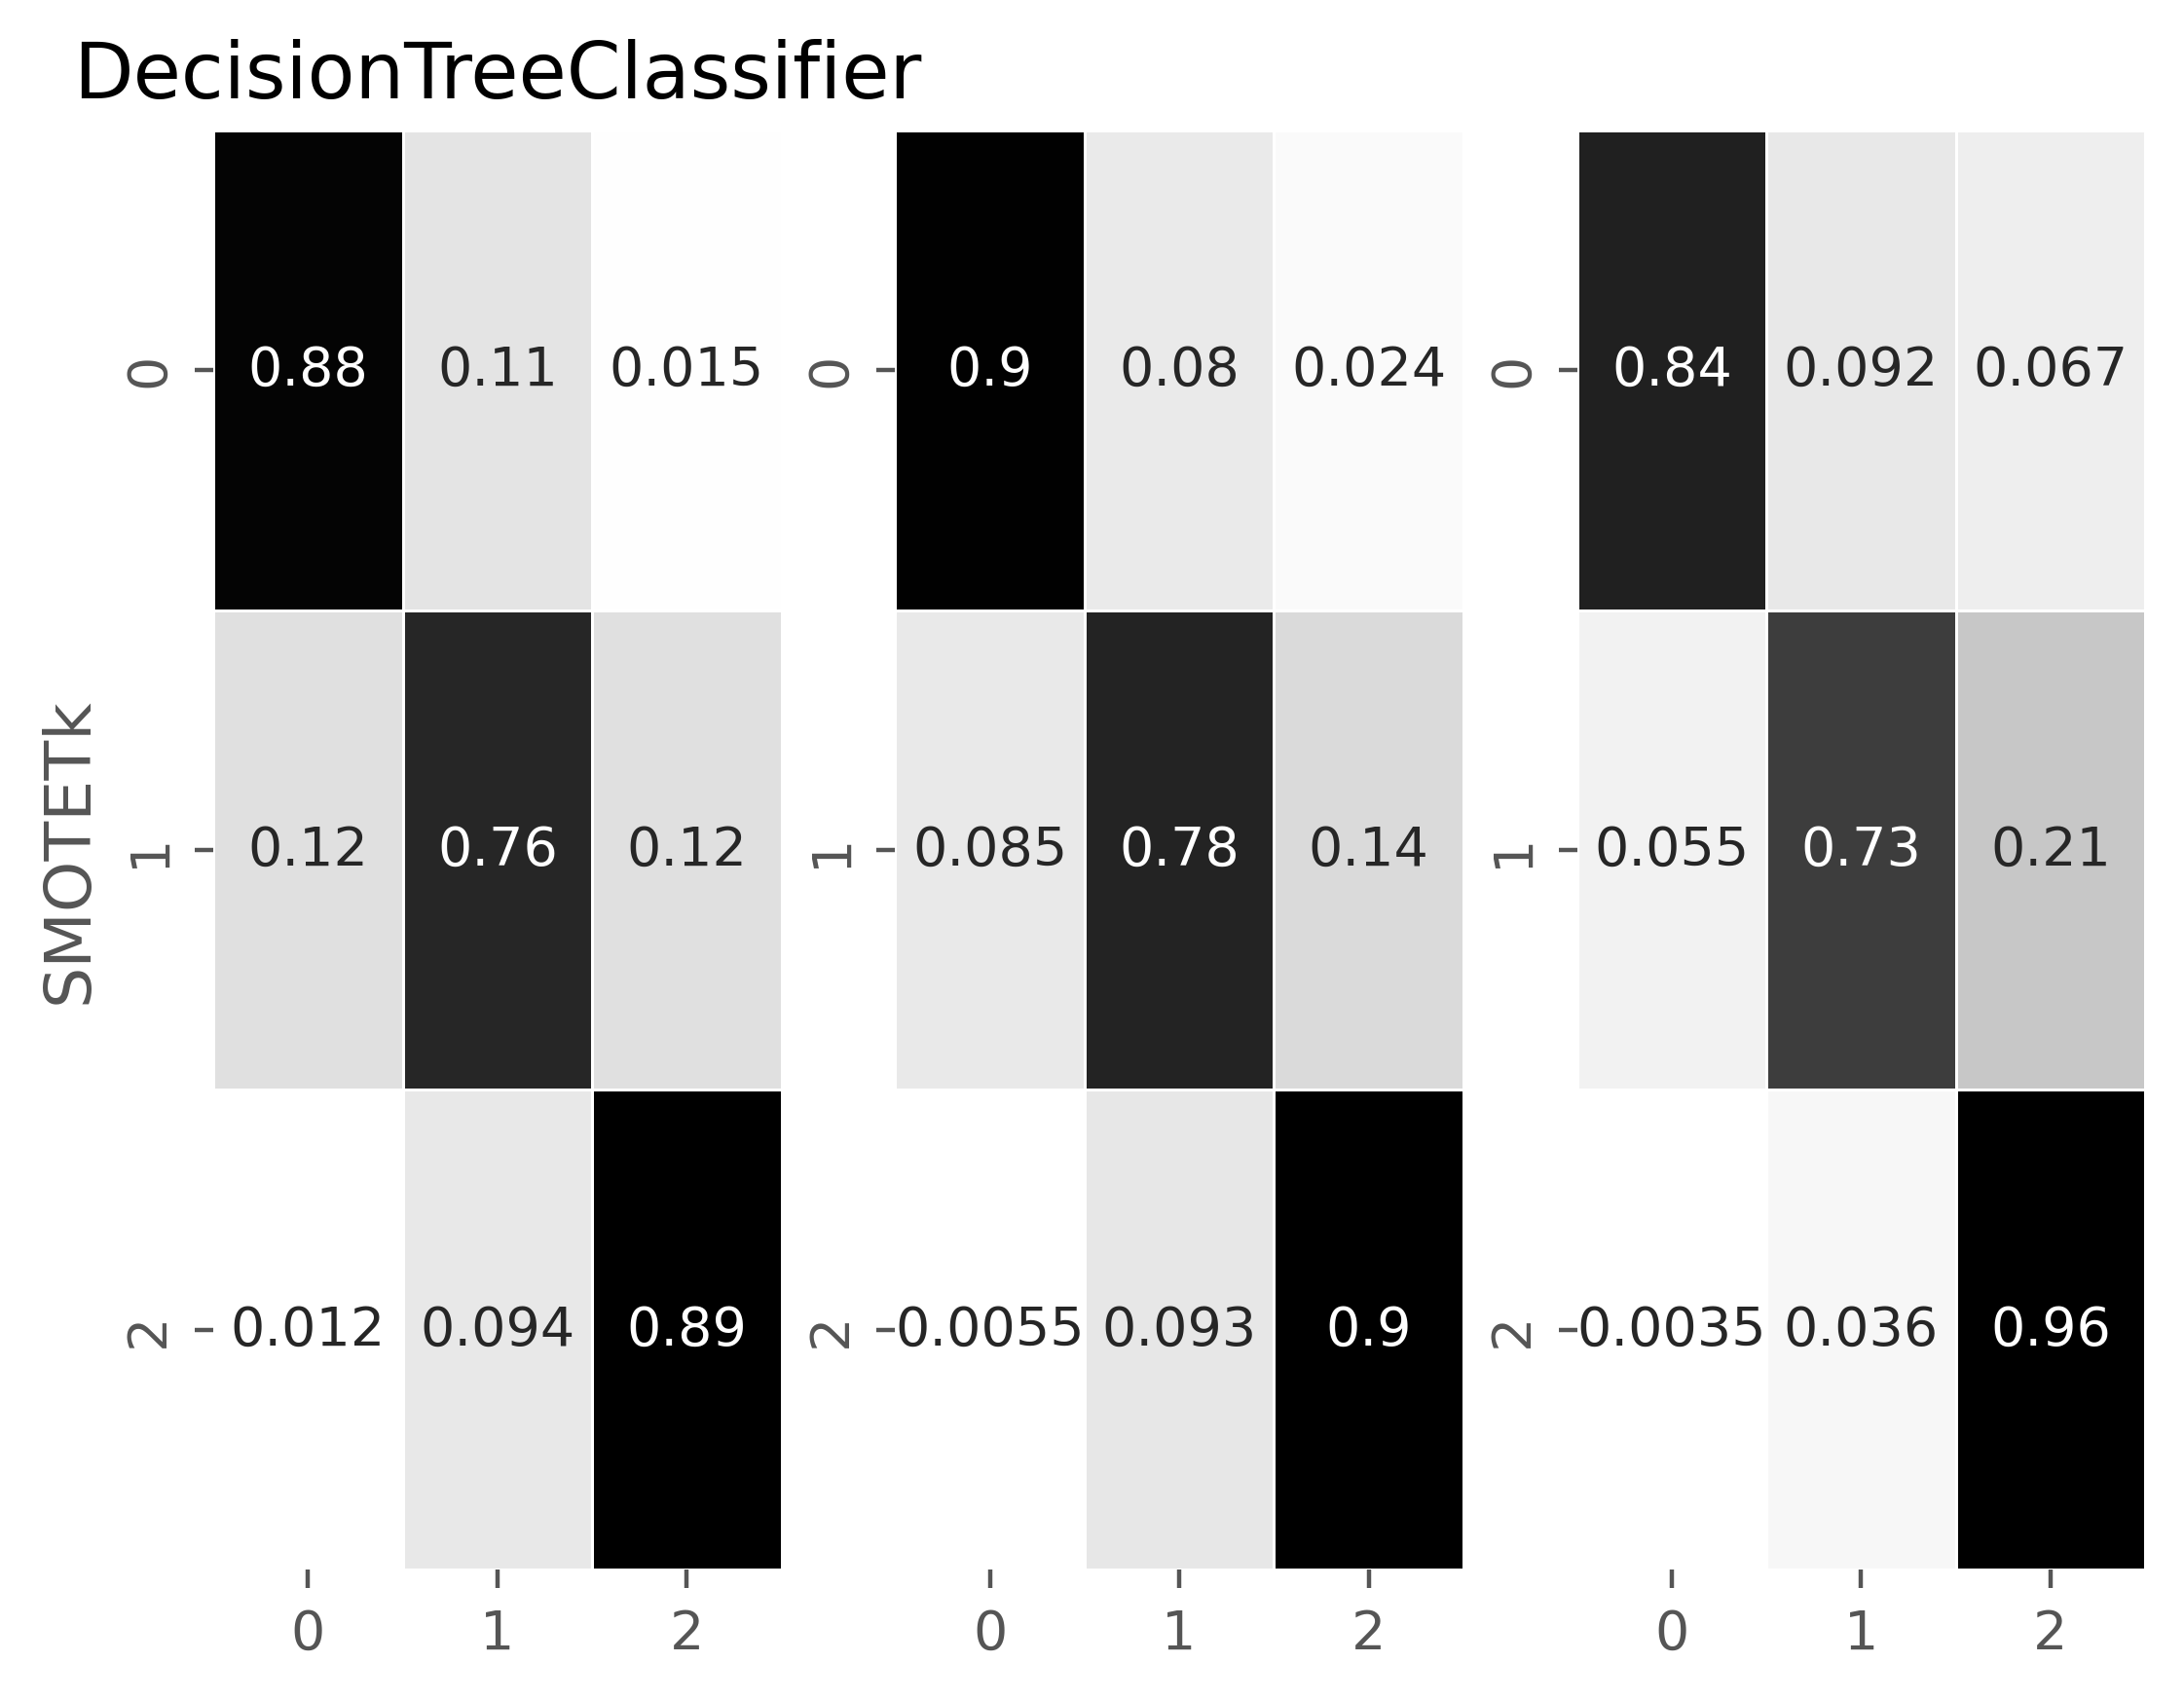

In [12]:
best_models=learn(
    sampling_dataset, 
    us_models, 
    show_confusion_matrix=True, 
    show_classification_report=True, 
    keep_all_models=True
)

### 保存模型

In [13]:
best_models

defaultdict(dict,
            {'SMOTETk': {'DecisionTreeClassifier': {'model': DecisionTreeClassifier(random_state=233),
               'acc': 0.8451529014618052},
              'OneVsOneClassifier': {'model': OneVsOneClassifier(estimator=DecisionTreeClassifier(), n_jobs=-1),
               'acc': 0.8588620984618205},
              'OneVsRestClassifier': {'model': OneVsRestClassifier(estimator=DecisionTreeClassifier(), n_jobs=-1),
               'acc': 0.8448034887806071}}})

In [14]:
smotetk_dt=best_models['SMOTETk']['DecisionTreeClassifier']['model']
dump(smotetk_dt, './data/new_experiment/SMOTETomek_DecisionTree')

['./data/new_experiment/SMOTETomek_DecisionTree']

In [18]:
smotetk_ovo=best_models['SMOTETk']['OneVsOneClassifier']['model']
dump(smotetk_ovo, './data/new_experiment/SMOTETomek_OneVsOneClassifier')

['./data/new_experiment/SMOTETomek_OneVsOneClassifier']

In [19]:
smotetk_ovr=best_models['SMOTETk']['OneVsRestClassifier']['model']
dump(smotetk_ovr, './data/new_experiment/SMOTETomek_OneVsRestClassifier')

['./data/new_experiment/SMOTETomek_OneVsRestClassifier']

In [20]:
!ls -alh ./data/new_experiment/

total 1.1G
drwxr-xr-x 3 root root 4.0K Feb 13 16:45 .
drwxr-xr-x 6 root root   98 Feb  6 18:14 ..
-rw-r--r-- 1 root root  38M Feb  8 13:01 CombineSampledData-0515-SMOTETomek.npz
-rw-r--r-- 1 root root 1.2K Feb  8 13:08 DataScaler
drwxr-xr-x 2 root root    6 Feb 10 16:09 .ipynb_checkpoints
-rw-r--r-- 1 root root 292M Feb 10 17:08 processed_data.npz
-rw-r--r-- 1 root root 275M Feb 10 13:21 raw_uk_data
-rw-r--r-- 1 root root  34M Feb  8 13:25 RENN_DecisionTree
-rw-r--r-- 1 root root  58M Feb 13 16:45 SMOTETomek_DecisionTree
-rw-r--r-- 1 root root  59M Feb 13 16:49 SMOTETomek_OneVsOneClassifier
-rw-r--r-- 1 root root 104M Feb 13 16:49 SMOTETomek_OneVsRestClassifier
-rw-r--r-- 1 root root 155M Feb 10 15:06 uk-0515-SMOTETomek_broken.npz
-rw-r--r-- 1 root root  96M Feb 10 17:04 uk-0515-SMOTETomek.npz
-rw-r--r-- 1 root root 9.1M Feb  6 18:14 UnderSampledData-0515-RepeatedENN.npz
-rw-r--r-- 1 root root 3.4M Feb  8 13:10 ValidData-1721.npz


# 采用17~21 年的数据进行检验

## 导入数据

In [21]:
!ls -alh data/new_experiment/

total 1.1G
drwxr-xr-x 3 root root 4.0K Feb 13 16:45 .
drwxr-xr-x 6 root root   98 Feb  6 18:14 ..
-rw-r--r-- 1 root root  38M Feb  8 13:01 CombineSampledData-0515-SMOTETomek.npz
-rw-r--r-- 1 root root 1.2K Feb  8 13:08 DataScaler
drwxr-xr-x 2 root root    6 Feb 10 16:09 .ipynb_checkpoints
-rw-r--r-- 1 root root 292M Feb 10 17:08 processed_data.npz
-rw-r--r-- 1 root root 275M Feb 10 13:21 raw_uk_data
-rw-r--r-- 1 root root  34M Feb  8 13:25 RENN_DecisionTree
-rw-r--r-- 1 root root  58M Feb 13 16:45 SMOTETomek_DecisionTree
-rw-r--r-- 1 root root  59M Feb 13 16:49 SMOTETomek_OneVsOneClassifier
-rw-r--r-- 1 root root 104M Feb 13 16:49 SMOTETomek_OneVsRestClassifier
-rw-r--r-- 1 root root 155M Feb 10 15:06 uk-0515-SMOTETomek_broken.npz
-rw-r--r-- 1 root root  96M Feb 10 17:04 uk-0515-SMOTETomek.npz
-rw-r--r-- 1 root root 9.1M Feb  6 18:14 UnderSampledData-0515-RepeatedENN.npz
-rw-r--r-- 1 root root 3.4M Feb  8 13:10 ValidData-1721.npz


In [22]:
# 读取数据
valid=np.load(file='./data/new_experiment/ValidData-1721.npz')
X_valid, y_valid=valid['X'], valid['y']

In [23]:
show_severity_distribution(y_valid)

NameError: name 'show_severity_distribution' is not defined

## 开始检验

In [32]:
smotetk_dt=load('./data/new_experiment/SMOTETomek_DecisionTree')

In [33]:
y_pred_smotetk_dt=smotetk_dt.predict(X_valid)

In [34]:
smotetk_ovo=load('./data/new_experiment/SMOTETomek_OneVsOneClassifier')

In [35]:
y_pred_smotetk_ovo=smotetk_ovo.predict(X_valid)

In [36]:
smotetk_ovr=load('./data/new_experiment/SMOTETomek_OneVsRestClassifier')

In [37]:
y_pred_smotetk_ovr=smotetk_ovr.predict(X_valid)

Text(0.5, 1.0, 'OneVsRest')

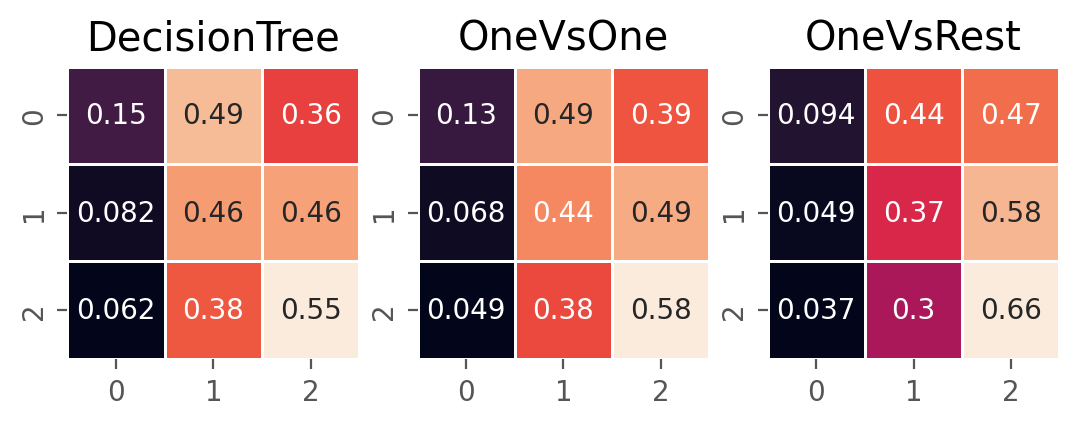

In [39]:
from sklearn.metrics import confusion_matrix

plt.subplot(1,3,1)
sns.heatmap(data=confusion_matrix(y_valid, y_pred_smotetk_dt, normalize='true') , annot=True, cbar=False, fmt='.2g', linewidths=0.5, square=True)
plt.title('DecisionTree')

plt.subplot(1,3,2)
sns.heatmap(data=confusion_matrix(y_valid, y_pred_smotetk_ovo, normalize='true'), annot=True, cbar=False, fmt='.2g', linewidths=0.5, square=True)
plt.title('OneVsOne')

plt.subplot(1,3,3)
sns.heatmap(data=confusion_matrix(y_valid, y_pred_smotetk_ovr, normalize='true'), annot=True, cbar=False, fmt='.2g', linewidths=0.5, square=True)
plt.title('OneVsRest')

In [54]:
m=ms['RepeatedEditedNearestNeighbours']['model']
print('model [%s] with acc = [%.4f]' % (m, ms['RepeatedEditedNearestNeighbours']['acc']))

model [BalancedRandomForestClassifier(n_jobs=-1)] with acc = [0.7909]


In [55]:
# 执行预测
y_p=m.predict(X_t)
test_acc=accuracy_score(y_t, y_p)
print(f'{m.__class__.__name__} [ test_acc]={test_acc*100:.2f}')

BalancedRandomForestClassifier [ test_acc]=56.80


<AxesSubplot: >

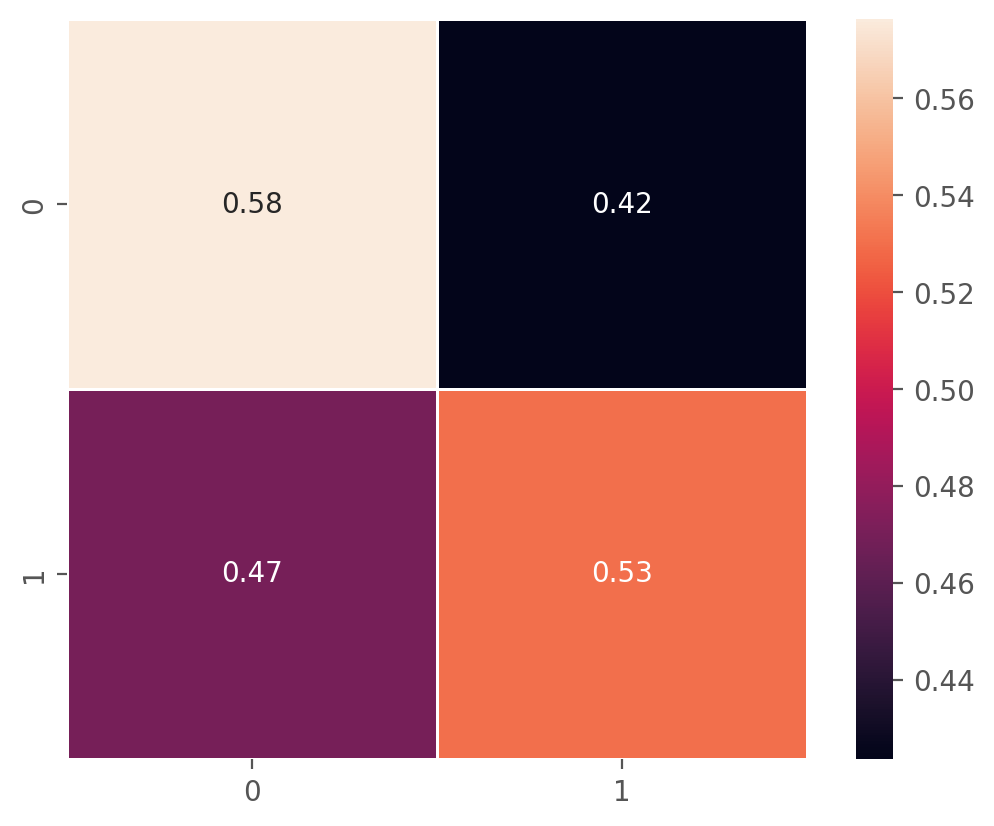

In [56]:
# 混淆矩阵
plt.figure()
sns.heatmap(data=confusion_matrix(y_t, y_p, normalize='true'), square=True, annot=True, fmt='.2g', linewidths=0.5)

In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [63]:
f1_score(y_t, y_p)

0.30639599555061175

In [64]:
recall_score(y_t, y_p)

0.5303745065947819

In [65]:
precision_score(y_t, y_p)

0.21542251593477496

In [ ]:
precision_recall_curve(y_t, m.decision_path(X_t))